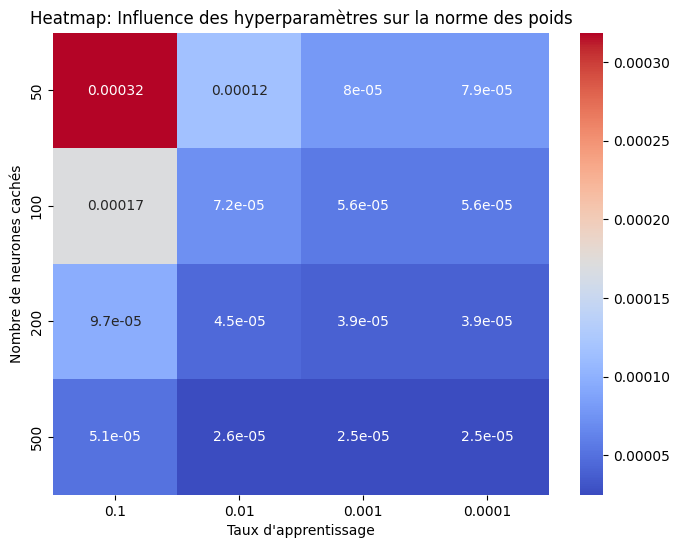

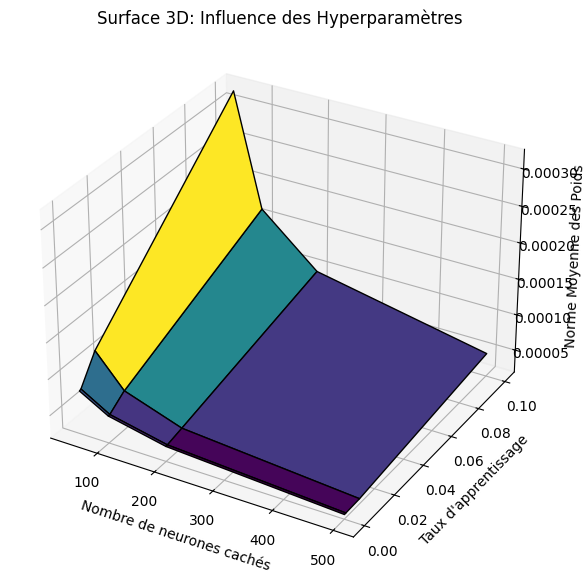

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

# Load the dataset
def lire_alpha_digit(indices):
    data = scipy.io.loadmat("binaryalphadigs.mat")
    images = []
    for idx in indices:
        for i in range(len(data['dat'][idx])):
            image = data['dat'][idx][i]
            image = np.array(image).flatten()
            images.append(image)
    return np.array(images)

# RBM class
class RBM:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.w = np.random.normal(0, 1, (p,q)) * 0.01
    
    def entree_sortie(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.w) - self.b))
    
    def sortie_entree(self, H):
        return 1 / (1 + np.exp(-np.dot(H, self.w.T) - self.a))
    
    def train(self, X, nb_epochs, taille_batch, epsilon):
        for epoch in range(nb_epochs):
            np.random.shuffle(X)
            for j in range(0, X.shape[0], taille_batch):
                X_batch = X[j:min(j + taille_batch, X.shape[0]), :]
                phv0 = self.entree_sortie(X_batch)
                h0 = (np.random.rand(*phv0.shape) < phv0).astype(int)
                pv1 = self.sortie_entree(h0)
                V_1 = (np.random.rand(*pv1.shape) < pv1).astype(int)
                phv1 = self.entree_sortie(V_1)
                self.w += (epsilon / X_batch.shape[0]) * (X_batch.T @ phv0 - V_1.T @ phv1)
                self.a += (epsilon / X_batch.shape[0]) * np.sum(X_batch - V_1, axis=0)
                self.b += (epsilon / X_batch.shape[0]) * np.sum(phv0 - phv1, axis=0)
        return np.linalg.norm(self.w) / (self.p * self.q)

# Load dataset
indices = [0, 1, 2, 3, 4]
X = lire_alpha_digit(indices)
p = X.shape[1]

# Hyperparamètres à tester
n_hidden_units_list = [50, 100, 200, 500]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_sizes = [10, 50, 100, 200]

# 1️⃣ HEATMAP : Influence du nombre de neurones et du taux d'apprentissage
results = np.zeros((len(n_hidden_units_list), len(learning_rates)))

for i, q in enumerate(n_hidden_units_list):
    for j, lr in enumerate(learning_rates):
        rbm = RBM(p, q)
        norme_poids = rbm.train(X, 10, 100, lr)  # Fixe taille batch = 100
        results[i, j] = norme_poids

plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, xticklabels=learning_rates, yticklabels=n_hidden_units_list, cmap="coolwarm")
plt.xlabel("Taux d'apprentissage")
plt.ylabel("Nombre de neurones cachés")
plt.title("Heatmap: Influence des hyperparamètres sur la norme des poids")
plt.show()

# 2️⃣ SURFACE PLOT : Influence du nombre de neurones, taux d'apprentissage et taille du batch
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X_vals, Y_vals = np.meshgrid(n_hidden_units_list, learning_rates)
Z_vals = np.zeros_like(X_vals, dtype=float)

for i in range(len(n_hidden_units_list)):
    for j in range(len(learning_rates)):
        rbm = RBM(p, n_hidden_units_list[i])
        norme_poids = rbm.train(X, 10, batch_sizes[2], learning_rates[j])  # Fixe taille batch = 100
        Z_vals[j, i] = norme_poids

ax.plot_surface(X_vals, Y_vals, Z_vals, cmap="viridis", edgecolor='k')
ax.set_xlabel("Nombre de neurones cachés")
ax.set_ylabel("Taux d'apprentissage")
ax.set_zlabel("Norme Moyenne des Poids")
ax.set_title("Surface 3D: Influence des Hyperparamètres")
plt.show()